# OCO-3 Snapshot Area Map (SAM) Exploration

While OCO-2 and OCO-3 use the same set of spectrometers, one development with OCO-3 has been the addition of a Pointing Mirror Assembly (PMA). The PMA allows for rapid changes in the pointing of the instrument, enabling data to be collected over contiguous 80km x 80km areas known as Snapshot Area Maps (SAMs). The science team maintains a repository of SAM acquisitions from throughout the mission on this webpage: [https://ocov3.jpl.nasa.gov/sams/](https://ocov3.jpl.nasa.gov/sams/)

In this notebook, we will look at SAMs acquired at one site in the Cascade Mountains region of the state of Oregon, United States. This region is composed predominantly of coniferous forest including cedars, Douglas firs, and pines. By comparing SAM acquisitions over time, we can observe the seasonal changes in SIF for this ecoregion. Additionally, there is a FLUXNET eddy covariance tower located within the boundaries of this site that can be used as a "ground truth" comparison to the values we observe with OCO-3.

In [ ]:
import contextily as ctx
from cartopy import crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Add src directory containing helper code to sys.path
sys.path.append(os.path.abspath("../src"))

from pysif import GesDiscDownloader, plot_samples

## I. Retrieving SAM Data

The [SAM webpage](https://ocov3.jpl.nasa.gov/sams/index.php) mentioned previously is a great place to start for finding specific sites and observations. In this exercise, we will be looking specifically at the `ecostress_us_me2` site, but you can pan through the map on the webpage to find a different area of interest on your own. If you put this site name and the site type ("SIF_Low", which can be found by clicking on the map pin for the site) into the search parameters, a list of all SAM observations at that site will be pulled up.  

<div align="center">
  <img src="images/ecostress_us_me2_map.png" alt="ecostress_us_me2 map pin">
</div>

These search results can tell us which dates we want to retrieve SIF granules for, and then filter those granules to only include soundings from the SAM mode, which is mode 2 in the granule. The retrieval itself can use the same code from the exploration notebook from earlier. To start let's take the first SAM observation with a non-zero amount of soundings, which we can see from the search results occurred on May 28th, 2020:

<div align="center">
  <img src="images/sam_search_result.png" alt="SAM mode search result">
</div>

In [10]:
dl = GesDiscDownloader()

dataset = "OCO3_L2_Lite_SIF.11r"
data_date = datetime(2020, 5, 28)
granule = dl.get_granule_by_date(dataset, data_date)

Checking available dates on GES DISC for OCO3_L2_Lite_SIF.11r


/Users/jryan/general/ARSET/SIF-ARSET/venv/lib/python3.13/site-packages/pydap/handlers/dap.py:134: UserWarning: PyDAP was unable to determine the DAP protocol defaulting to DAP2. DAP2 is consider legacy and may result in slower responses. 
Consider replacing `http` in your `url` with either `dap2` or `dap4` to specify the DAP protocol (e.g. `dap2://<data_url>` or `dap4://<data_url>`).  For more 
information, go to https://www.opendap.org/faq-page.
  warnings.warn(


In [7]:
meas_mode = np.array(granule["Metadata_MeasurementMode"].data[:])
qual_flag = np.array(granule["Quality_Flag"].data[:])
sam_mask  = (meas_mode == 3) & ((qual_flag == 0) | (qual_flag == 1))

footprint_lon = granule["Geolocation_footprint_longitude_vertices"].data[:]
footprint_lat = granule["Geolocation_footprint_latitude_vertices"].data[:]

sam_foot_lon = footprint_lon[sam_mask][:]
sam_foot_lat = footprint_lat[sam_mask][:]
print(sam_foot_lon)

[[-123.61328  -123.59003  -123.5896   -123.613525]
 [-123.613525 -123.58911  -123.58954  -123.61267 ]
 [-123.59003  -123.56482  -123.564514 -123.5896  ]
 ...
 [ -95.7124    -95.68982   -95.71472   -95.73767 ]
 [ -95.737     -95.71399   -95.7395    -95.76245 ]
 [ -95.76178   -95.73889   -95.7641    -95.78717 ]]


Now that we have the granule, we can filter the data to just SAM soundings. You can find more information about OCO-3's measurement modes in the [User's Guide](https://docserver.gesdisc.eosdis.nasa.gov/public/project/OCO/OCO2_v11.2_OCO3_v11_SIF_Data_Users_Guide.pdf), see Section 4.7 "The Metadata Group". Measurement Mode 3 is referred to as an AreaMap -- this is the SAM mode we are interested in.

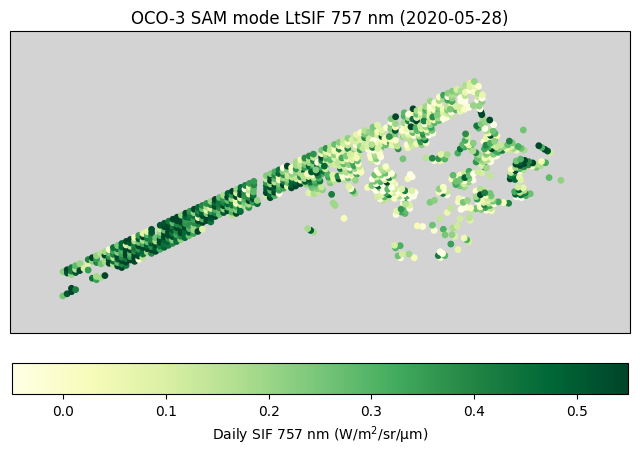

In [22]:
# Get the measurement mode of the data first so we can filter to just use SAM mode soundings
# Additionally, we will remove low quality soundings
meas_mode = np.array(granule["Metadata_MeasurementMode"].data[:])
qual_flag = np.array(granule["Quality_Flag"].data[:])
sam_mask  = (meas_mode == 3) & ((qual_flag == 0) | (qual_flag == 1))

all_lat = granule["Latitude"].data[:]
all_lon = granule["Longitude"].data[:]
all_sif = granule["Daily_SIF_757nm"].data[:]

lat = all_lat[sam_mask]
lon = all_lon[sam_mask]
sif = all_sif[sam_mask]

sam_extent = [-123.9, -120.4, 43.3, 45]

# Using the plot_samples function from the first notebook gives us a good first look at this data
# before further processing. The YlGn colormap is used to make it easier to compare the data with
# the official plot.
plot_samples(
    sif, lat, lon,
    vmin=-0.05,
    vmax=0.55,
    cmap="YlGn",
    point_size=15,
    fig_size=(8, 8),
    extents=sam_extent,
    title=f"OCO-3 SAM mode LtSIF 757 nm ({data_date.strftime('%Y-%m-%d')})",
    label=r"Daily SIF 757 nm (W/$\mathrm{m}^2$/sr/μm)"
)

### Comparison with official plot
If you've been following along on the OCO-3 website, you may have noticed that the science team provides pre-made plots of a variety of measurements for each SAM acquisition. Let's take a look at one of these plots for the OCO-3 LtSIF 757nm variable:

<div style="text-align:center">
  <img style="width:640px" src="images/OCO3_Lite_B11074Ar_r02_sif_757nm_20200528_6040_ecostress_us_me2.png" alt="Official OCO-3 SAM mode plot for May 28, 2020">
</div>

If the previous code ran successfully for you, you should be able to see that our plot is already comparable to the official one and that we are at least looking at the same data but with some superficial differences in presentation. In the next section, we will refine our plot to look like the official version. The most important component of this will be to adjust each sounding to use its proper footprint extents.

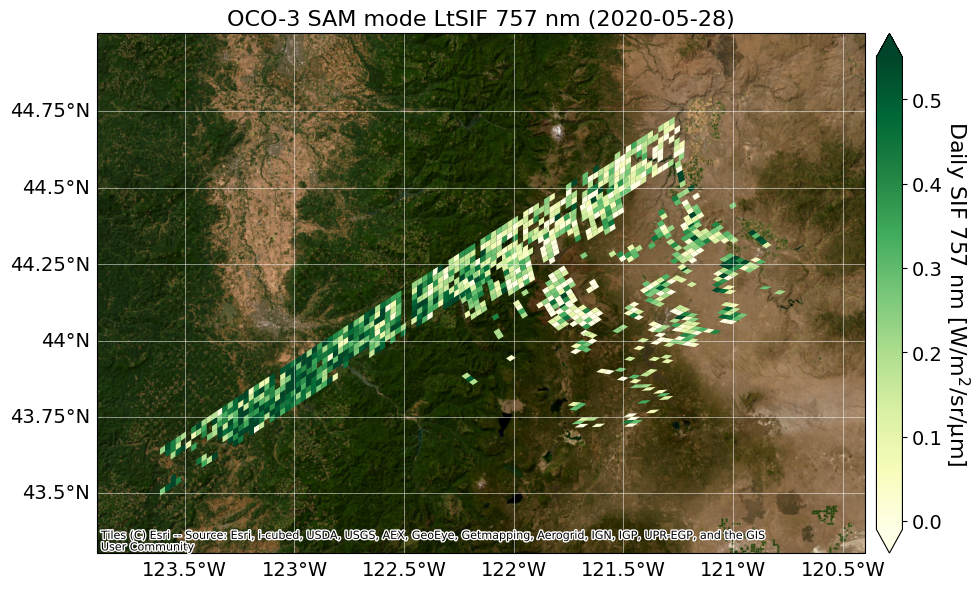

In [23]:
all_footlat = granule["Geolocation_footprint_latitude_vertices"].data[:]
all_footlon = granule["Geolocation_footprint_longitude_vertices"].data[:]
footprint_lat = all_footlat[sam_mask][:]
footprint_lon = all_footlon[sam_mask][:]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.GOOGLE_MERCATOR)

ax.set_extent(sam_extent, crs=ccrs.PlateCarree())
'''
scatter = ax.scatter(
    lon, lat,
    c=sif,
    cmap="YlGn",
    s=15,
    vmin=-0.01,
    vmax=0.55,
    transform=ccrs.PlateCarree()
)
'''
patches_list = []
for i in range(len(sif)):
    polygon = patches.Polygon(np.column_stack([footprint_lon[i], footprint_lat[i]]))
    patches_list.append(polygon)

pcol = PatchCollection(
    patches_list,
    cmap="YlGn",
    transform=ccrs.PlateCarree()
)

pcol.set_array(np.array(sif))
pcol.set_clim(-0.01, 0.55)
sif_layer = ax.add_collection(pcol)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,
    crs=ccrs.GOOGLE_MERCATOR,
    zoom=9
)

# Add gridlines over the map. Note that we can use the default LATITUDE_FORMATTER and
# LONGITUDE_FORMATTER from cartopy to make our lives easier
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="white", alpha=0.7, linestyle="-")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 14, "color": "black"}
gl.ylabel_style = {"size": 14, "color": "black"}


plt.title(f"OCO-3 SAM mode LtSIF 757 nm ({data_date.strftime('%Y-%m-%d')})", fontsize=16)
cbar = plt.colorbar(sif_layer, ax=ax, extend="both", pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Daily SIF 757 nm [W/$\mathrm{m}^2$/sr/μm]", fontsize=16, rotation=270, labelpad=20)

plt.tight_layout()
plt.show()